# Proyek Klasifikasi Gambar: Vehicle Images Dataset
- **Nama:** Andi Nabilah Putri Maharani A
- **Email:** andinabilahptr@gmail.com
- **ID Dicoding:** M891D5X0211

## Import Semua Packages/Library yang Digunakan

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Data Preparation

### Data Loading

In [2]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"andinabilahputri","key":"96f48d78be4dab4c0179542856b2d7ec"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d lyensoetanto/vehicle-images-dataset

zip_path = "/content/vehicle-images-dataset.zip"
extract_path = "/content/dataset_all"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset diekstrak ke:", extract_path)
print("Isi folder:", os.listdir(extract_path))

Dataset URL: https://www.kaggle.com/datasets/lyensoetanto/vehicle-images-dataset
License(s): unknown
vehicle-images-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Dataset diekstrak ke: /content/dataset_all
Isi folder: ['Sport Utility Vehicle', 'Van', 'Truck', 'Multi Purpose Vehicle', 'City Car', 'Big Truck', 'Sedan']


### Data Preprocessing

#### Split Dataset

In [4]:
base_dir = "/content/dataset_all"

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=123
)

val_test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.5)

val_gen = val_test_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=123
)

test_gen = val_test_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    seed=123
)


Found 12519 images belonging to 7 classes.
Found 7825 images belonging to 7 classes.
Found 7820 images belonging to 7 classes.


##Modeling

In [5]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_gen.num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,255 (18.42 MB)

 Trainable params: 4,829,255 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),

    ModelCheckpoint(
        filepath='/content/best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),

    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-5,
        verbose=1
    )
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


391/392 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3131 - loss: 1.6954
Epoch 1: val_accuracy improved from -inf to 0.49304, saving model to /content/best_model.keras
392/392 ━━━━━━━━━━━━━━━━━━━━ 31s 59ms/step - accuracy: 0.3134 - loss: 1.6947 - val_accuracy: 0.4930 - val_loss: 1.2226 - learning_rate: 0.0010
Epoch 2/30
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4536 - loss: 1.3018
Epoch 2: val_accuracy improved from 0.49304 to 0.58441, saving model to /content/best_model.keras
392/392 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.4537 - loss: 1.3017 - val_accuracy: 0.5844 - val_loss: 1.0503 - learning_rate: 0.0010
Epoch 3/30
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5506 - loss: 1.0803
Epoch 3: val_accuracy improved from 0.58441 to 0.71105, saving model to /content/best_model.keras
392/392 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.5506 - loss: 1.0802 - val_accuracy: 0.7111 - val_loss: 0.7490 - learning_rate: 0.0010
Epoch 4/30
391/392 ━━━━━━━━━━━

## Evaluasi dan Visualisasi

In [7]:
best_model = load_model('/content/best_model.keras')
test_loss, test_acc = best_model.evaluate(test_gen)
print(f"Akurasi model terbaik di test set: {test_acc * 100:.2f}%")

245/245 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9465 - loss: 0.2694
Akurasi model terbaik di test set: 94.78%


245/245 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step


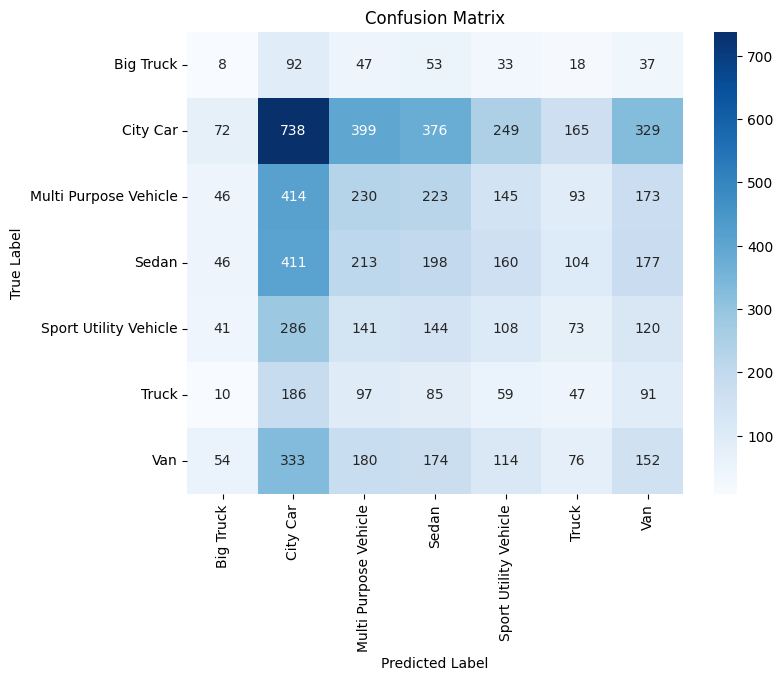

In [8]:
test_gen.shuffle = False

# Prediksi
Y_pred = best_model.predict(test_gen)
y_pred = np.argmax(Y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

# Label kelas
labels = list(test_gen.class_indices.keys())

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

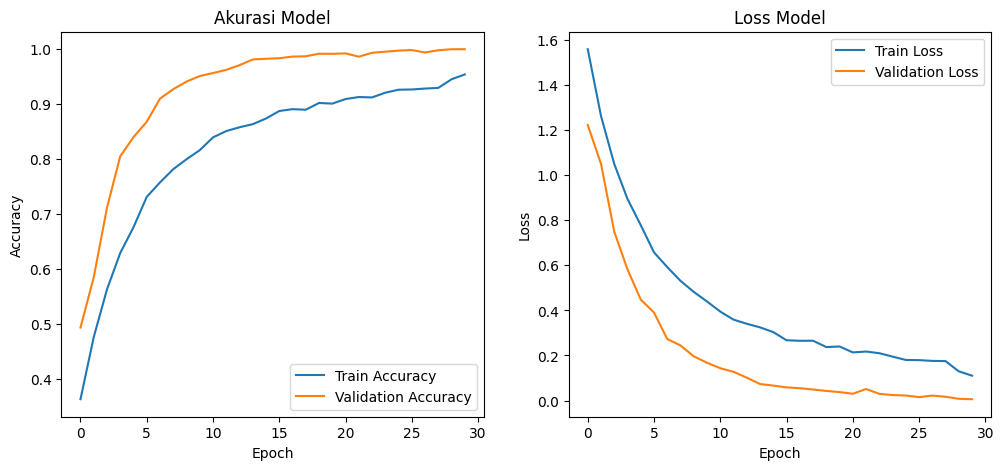

In [9]:
#Visualisasi
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Konversi Model

In [10]:
!pip install tensorflowjs

In [11]:
#Format SavedModel
saved_model_dir = '/content/model_vehicle_cnn'
model.export(saved_model_dir)
print("✅ Model disimpan dalam format SavedModel")

#Format TF-Lite
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()
with open('/content/model_vehicle_cnn.tflite', 'wb') as f:
    f.write(tflite_model)
print("✅ Model disimpan dalam format TF-Lite")

#Format TFJS
!mkdir -p /content/model_tfjs
!tensorflowjs_converter --input_format=tf_saved_model \
  --saved_model_tags=serve {saved_model_dir} /content/model_tfjs
print("✅ Model disimpan dalam format TFJS")

Saved artifact at '/content/model_vehicle_cnn'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  134855733559760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134855733560528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134855733560144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134855733562640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134855733561872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134855733563600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134855733563024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134855733563216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134855733563408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134855733564560: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ Mode

In [12]:
!pip freeze > requirements.txt